In [27]:
%matplotlib inline

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import warnings
from joblib import dump, load
from typing import List, Any, Dict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt




nltk.download('stopwords')
def warn(*args, **kwargs):
    pass

warnings.warn = warn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load dataset. You can use your own

In [18]:
df = pd.read_csv('./dataset_for_assignment.csv')
df.head()

,comment_text,target
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Examples of class '1' is 16225 . Examples of class '0' is 143346
Ratio of classes:  0.1131876717871444


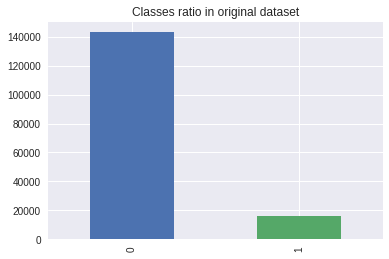

In [19]:
groups = df.groupby(['target']).agg({'target': 'count'}).to_dict('index')
print("Examples of class '1' is", groups[1]['target'], ". Examples of class '0' is", groups[0]['target'])
print("Ratio of classes: ", groups[1]['target'] / groups[0]['target'])
df.target.value_counts().plot(kind='bar', title='Classes ratio in original dataset');

# Text pre-processing

In [20]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;\\n]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def loss_0_1(model, xs: List[str], ys: List[int]):
  predicted = model.predict(xs)
  return np.mean(predicted == ys)


def clean_text(text: str) -> str:
    '''Clean text'''
       
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
    
df['comment_text'] = df['comment_text'].apply(clean_text)
df.head()


,comment_text,target
0,explanation edits made username hardcore metal...,0
1,daww matches background colour im seemingly st...,0
2,hey man im really trying edit war guy constant...,0
3,cant make real suggestions improvement wondere...,0
4,sir hero chance remember page thats,0


### All experements bellow we will do for:


1.   original dataset (imbalanced)
2.   undersampled
3.   oversampled



## Dataset Undersampling

---



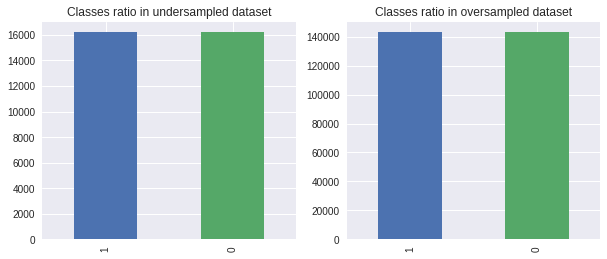

In [32]:
# undersampling
indexies_class_0 = df[df.target == 0].index.tolist()
indexies_class_1 = df[df.target == 1].index.tolist()
random_indices_class_0 = np.random.choice(indexies_class_0, len(indexies_class_1), replace=False).tolist()
df_balanced_under = df.loc[random_indices_class_0 + indexies_class_1]

# oversampling
df_class_0 = df[df.target == 0]
df_class_1_over = df[df.target == 1].sample(len(df_class_0), replace=True)
df_balanced_over = pd.concat([df_class_0, df_class_1_over], axis=0)


df_train, df_test = train_test_split(df, shuffle=True, test_size=0.15)
df_train_under, df_test_under = train_test_split(df_balanced_under, shuffle=True, test_size=0.15)
df_train_over, df_test_over = train_test_split(df_balanced_over, shuffle=True, test_size=0.15)

X = df_train.comment_text.tolist()
Y = df_train.target.tolist()
Xb = df_train_under.comment_text.tolist()
Yb = df_train_under.target.tolist()
Xo = df_train_over.comment_text.tolist()
Yo = df_train_over.target.tolist()

  
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
df_balanced_under.target.value_counts().plot(kind='bar', title='Classes ratio in undersampled dataset', ax=axes[0])
df_balanced_over.target.value_counts().plot(kind='bar', title='Classes ratio in oversampled dataset', ax=axes[1])
  
def mk_clf_report(
    pipeline: Pipeline, 
    parameters: Dict[str, Any], 
    df_train: pd.DataFrame, 
    df_test: pd.DataFrame, 
    df_other_class_0: pd.DataFrame=None
):
  
  X = df_train.comment_text.tolist()
  Y = df_train.target.tolist()
  
  gs = GridSearchCV(pipeline, parameters, cv=5, iid=False, n_jobs=-1)
  gs = gs.fit(X, Y)
  
  # test
  predicted = gs.predict(df_test.comment_text.tolist())
  report = classification_report(
      y_true=df_test.target.tolist(), 
      y_pred=predicted
  )
#   if df_other_class_0 is not None:
#     loss = loss_0_1(
#         gs,
#         df_other_class_0.comment_text.tolist(), 
#         df_other_class_0.target.tolist()
#     )
#   else:
#     loss = None
    
  return gs, report #, loss
  


# Multinomial Naive Bayes


---



In [0]:
ppl = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=False)),
    ('clf', MultinomialNB(fit_prior=False)),
])

parameters = {
  'tfidf__sublinear_tf': [True, False],
  'clf__fit_prior':      [True, False]
}


###  Imbalanced dataset

In [35]:
gs, report = mk_clf_report(ppl, parameters, df_train, df_test)
print(report)
print(f'Best params:', gs.best_params_)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     21522
           1       0.84      0.45      0.58      2414

   micro avg       0.94      0.94      0.94     23936
   macro avg       0.89      0.72      0.77     23936
weighted avg       0.93      0.94      0.93     23936

Best params: {'clf__fit_prior': False, 'tfidf__sublinear_tf': True}


### Balanced dataset (undersampled)

In [36]:
gs, report = mk_clf_report(ppl, parameters, df_train_under, df_test_under)
print(report)
print('Best params:', gs.best_params_)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2436
           1       0.90      0.86      0.88      2432

   micro avg       0.89      0.89      0.89      4868
   macro avg       0.89      0.89      0.89      4868
weighted avg       0.89      0.89      0.89      4868

Best params: {'clf__fit_prior': False, 'tfidf__sublinear_tf': True}


### Balanced dataset (oversampled)

In [37]:
gs, report = mk_clf_report(ppl, parameters, df_train_over, df_test_over)
print(report)
print('Best params:', gs.best_params_)

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     21408
           1       0.90      0.95      0.93     21596

   micro avg       0.93      0.93      0.93     43004
   macro avg       0.93      0.93      0.93     43004
weighted avg       0.93      0.93      0.93     43004

Best params: {'clf__fit_prior': True, 'tfidf__sublinear_tf': True}


# Bernuolli Naive Bayes
---

In [0]:
ppl = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('clf', BernoulliNB(binarize=0.0, fit_prior=True)),
])

parameters = {
  'tfidf__use_idf': [True, False],
  'clf__fit_prior': [True, False]
}



###  Imbalanced dataset

In [39]:
gs, report = mk_clf_report(ppl, parameters, df_train, df_test)
print(report)
print('Best params:', gs.best_params_)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     21522
           1       0.86      0.54      0.66      2414

   micro avg       0.94      0.94      0.94     23936
   macro avg       0.91      0.76      0.82     23936
weighted avg       0.94      0.94      0.94     23936

Best params: {'clf__fit_prior': False, 'tfidf__use_idf': True}


### Balanced dataset (undersampled)

In [40]:
gs, report = mk_clf_report(ppl, parameters, df_train_under, df_test_under)
print(report)
print('Best params:', gs.best_params_)

              precision    recall  f1-score   support

           0       0.87      0.54      0.67      2436
           1       0.67      0.92      0.77      2432

   micro avg       0.73      0.73      0.73      4868
   macro avg       0.77      0.73      0.72      4868
weighted avg       0.77      0.73      0.72      4868

Best params: {'clf__fit_prior': True, 'tfidf__use_idf': True}


### Balanced dataset (oversampled)

In [41]:
gs, report = mk_clf_report(ppl, parameters, df_train_over, df_test_over)
print(report)
print('Best params:', gs.best_params_)

              precision    recall  f1-score   support

           0       0.93      0.58      0.72     21408
           1       0.70      0.96      0.81     21596

   micro avg       0.77      0.77      0.77     43004
   macro avg       0.81      0.77      0.76     43004
weighted avg       0.81      0.77      0.76     43004

Best params: {'clf__fit_prior': True, 'tfidf__use_idf': True}


# SVM & Logistic Regression
---

In [0]:
ppl = Pipeline([
    ('l0', CountVectorizer()),
    ('l1', TfidfTransformer(use_idf=True)),
    ('l3', SGDClassifier(
        loss='hinge', 
        penalty='l2', 
        alpha=1e-5, 
        random_state=17, 
        max_iter=10, 
        tol=None,
        early_stopping=True
    )),
])
parameters = {
  'l1__use_idf': [True],
  'l3__alpha': [1e-5, 1e-4],
  'l3__loss': ['hinge', 'log'],
  'l3__penalty': ['l2', 'l1']
}


###  Imbalanced dataset

In [169]:
gs, report = mk_clf_report(ppl, parameters, df_train, df_test)
print(report)
print('Best params:', gs.best_params_)
dump(gs.best_estimator_, 'SGDClassifier.joblib')

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     21473
           1       0.91      0.66      0.77      2463

   micro avg       0.96      0.96      0.96     23936
   macro avg       0.94      0.83      0.87     23936
weighted avg       0.96      0.96      0.96     23936

Best params: {'l1__use_idf': True, 'l3__alpha': 1e-05, 'l3__loss': 'hinge', 'l3__penalty': 'l2'}


['SGDClassifier.joblib']

### Balanced dataset (undersampled)

In [159]:
gs, report = mk_clf_report(ppl, parameters, df_train_under, df_test_under)
print(report)
print('Best params:', gs.best_params_)

dump(gs.best_estimator_, 'SGDClassifier_balanced_under.joblib')


              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2436
           1       0.93      0.88      0.90      2432

   micro avg       0.90      0.90      0.90      4868
   macro avg       0.91      0.90      0.90      4868
weighted avg       0.91      0.90      0.90      4868

Best params: {'l1__use_idf': True, 'l3__alpha': 1e-05, 'l3__loss': 'log', 'l3__penalty': 'l1'}
0-1 loss for sample of only class "0": 0.9271638832293642


['SGDClassifier_balanced.joblib']

### Balanced dataset (oversampled)

In [43]:
gs, report = mk_clf_report(ppl, parameters, df_train_over, df_test_over)
print(report)
print('Best params:', gs.best_params_)
dump(gs.best_estimator_, 'SGDClassifier_balanced_over.joblib')

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     21408
           1       0.96      0.98      0.97     21596

   micro avg       0.97      0.97      0.97     43004
   macro avg       0.97      0.97      0.97     43004
weighted avg       0.97      0.97      0.97     43004

Best params: {'l1__use_idf': True, 'l3__alpha': 1e-05, 'l3__loss': 'hinge', 'l3__penalty': 'l2'}


['SGDClassifier_balanced_over.joblib']

# Conclusions

Having that both classes are equally important for us we prefer to take SVM model as a baseline. We take version trained on oversampled dataset.
